In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import string
from nltk.corpus import stopwords
import emoji
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.naive_bayes import MultinomialNB

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from matplotlib.pyplot import figure

import itertools
import matplotlib.patches as mpatches

In [2]:
data = pd.read_csv('Tweets.csv')
data.drop(data.columns.difference(['airline_sentiment','text']), 1, inplace=True)

In [3]:
def preprocessing(data, parameters):
    negations = ['no', 'No', 'not', 'Not']
    
    porter = PorterStemmer()
    lancaster = LancasterStemmer()

    if(parameters[0]):
        data['text'] = data['text'].apply(lambda x: emoji.demojize(x))
    if(parameters[1]):
        data['text'] = data['text'].apply(lambda x: re.sub(r'[^\w\s]','',x))
    if(parameters[2]):
        data['text'] = data.text.str.replace('http\S+|www.\S+', '', case=False).str.replace('\d+', '')
    
    data['text'] = data.text.str.split()
    
    if(parameters[3]):
        data['text'] = data['text'].apply(lambda x: [word for word in x if word not in stopwords.words('english')])
    if(parameters[4]):
        data['text'] = data['text'].apply(lambda x: [word for word in x if word not in negations])
    if(parameters[5]):
        data['text'] = data['text'].apply(lambda x: [porter.stem(word) for word in x])
    if(parameters[6]):
        data['text'] = data['text'].apply(lambda x: [lancaster.stem(word) for word in x])
    
    data['text'] = data.text.str.join(' ')
        
    return data

In [4]:
def generateClassPrior(train_targets):
    count_targets = Counter(train_targets)
                
    negative_weight = (count_targets['negative'] / len(train_targets))
    neutral_weight = (count_targets['neutral'] / len(train_targets))
    positive_weight = (count_targets['positive'] / len(train_targets))

    cp = [negative_weight, neutral_weight, positive_weight]
    
    return cp

In [5]:
def checkNBClassifications(data, how_many_loops):
    best_error_rate_without_cp = 100
    best_error_rate_with_cp = 100
    
    size = 0.3
    for i in range(2 * how_many_loops):
        X_train, X_test, y_train, y_test = train_test_split(data['text'], data['airline_sentiment'], test_size = size)

        count_words = CountVectorizer()#n_gram = (1,2)
        train_words = count_words.fit_transform(X_train)
        train_targets = y_train

        if(i > how_many_loops):
            clf = MultinomialNB(alpha = 0.2)
        else:               
            cp = generateClassPrior(train_targets)
            clf = MultinomialNB(alpha = 0.2, class_prior = cp)

        clf.fit(train_words, train_targets)

        test_words = count_words.transform(X_test)

        predicts = clf.predict(test_words)

        error_rate = (sum(predicts != y_test) / len(y_test)) * 100

        if(i > how_many_loops):
            if(error_rate < best_error_rate_without_cp):
                best_error_rate_without_cp = error_rate
        else:
            if(error_rate < best_error_rate_with_cp):
                best_error_rate_with_cp = error_rate
    
    return [best_error_rate_without_cp, best_error_rate_with_cp]

In [6]:
def testAllCombinations(size = 7, crossvalidation = 5):
    parameters = list(itertools.product([0, 1], repeat = size))
    parameters = [x for x in parameters if x[-1] != x[-2] or x[-1] == 0]

    errors = []

    for parameter in (parameters):
        actual_preprocessed_data = preprocessing(data.copy(), parameter)
        
        errors.append(checkNBClassifications(actual_preprocessed_data, crossvalidation))
        print(len(errors) / len(parameters))
            
    return [errors, parameters]
    

In [13]:
testing_array = testAllCombinations()

0.010416666666666666
0.020833333333333332
0.03125
0.041666666666666664
0.052083333333333336
0.0625
0.07291666666666667
0.08333333333333333
0.09375
0.10416666666666667
0.11458333333333333
0.125
0.13541666666666666
0.14583333333333334
0.15625
0.16666666666666666
0.17708333333333334
0.1875
0.19791666666666666
0.20833333333333334
0.21875
0.22916666666666666
0.23958333333333334
0.25
0.2604166666666667
0.2708333333333333
0.28125
0.2916666666666667
0.3020833333333333
0.3125
0.3229166666666667
0.3333333333333333
0.34375
0.3541666666666667
0.3645833333333333
0.375
0.3854166666666667
0.3958333333333333
0.40625
0.4166666666666667
0.4270833333333333
0.4375
0.4479166666666667
0.4583333333333333
0.46875
0.4791666666666667
0.4895833333333333
0.5
0.5104166666666666
0.5208333333333334
0.53125
0.5416666666666666
0.5520833333333334
0.5625
0.5729166666666666
0.5833333333333334
0.59375
0.6041666666666666
0.6145833333333334
0.625
0.6354166666666666
0.6458333333333334
0.65625
0.6666666666666666
0.67708333333

In [14]:
def changeErrorRatesToAccuracy(error_rates):
    for i in range(len(error_rates)):
        error_rates[i] = 100 - error_rates[i]
    return error_rates

In [18]:
def plotErrorRates(errors_and_parameters):
    errors = errors_and_parameters[0]
    errors_without_cp = [i[0] for i in errors]
    errors_with_cp = [i[1] for i in errors]
    
    errors_without_cp = changeErrorRatesToAccuracy(errors_without_cp.copy())
    errors_with_cp = changeErrorRatesToAccuracy(errors_with_cp.copy())
    
    parameters = errors_and_parameters[1]    
    parameters = np.sum(parameters, 1)
    
    figure(figsize = (18, 16))
    plt.scatter(errors_without_cp, parameters, c='red',cmap='spring', edgecolors='k', s=40, label='Predictions without class prior')
    plt.scatter(errors_with_cp, parameters, c='blue', cmap='spring', edgecolors='k', s=40, label='Predictions with class prior')
    plt.xlabel('accuracy')
    plt.ylabel('amount of used preprocessing settings')
    
    legend_blue = mpatches.Circle(45, color='#0000ff', label='Predictions with class prior')
    legend_red = mpatches.Circle(45, color='#ff0000', label='Predictions without class prior')

    plt.savefig('firstplot.jpg')
    
    plt.legend(loc='upper left')


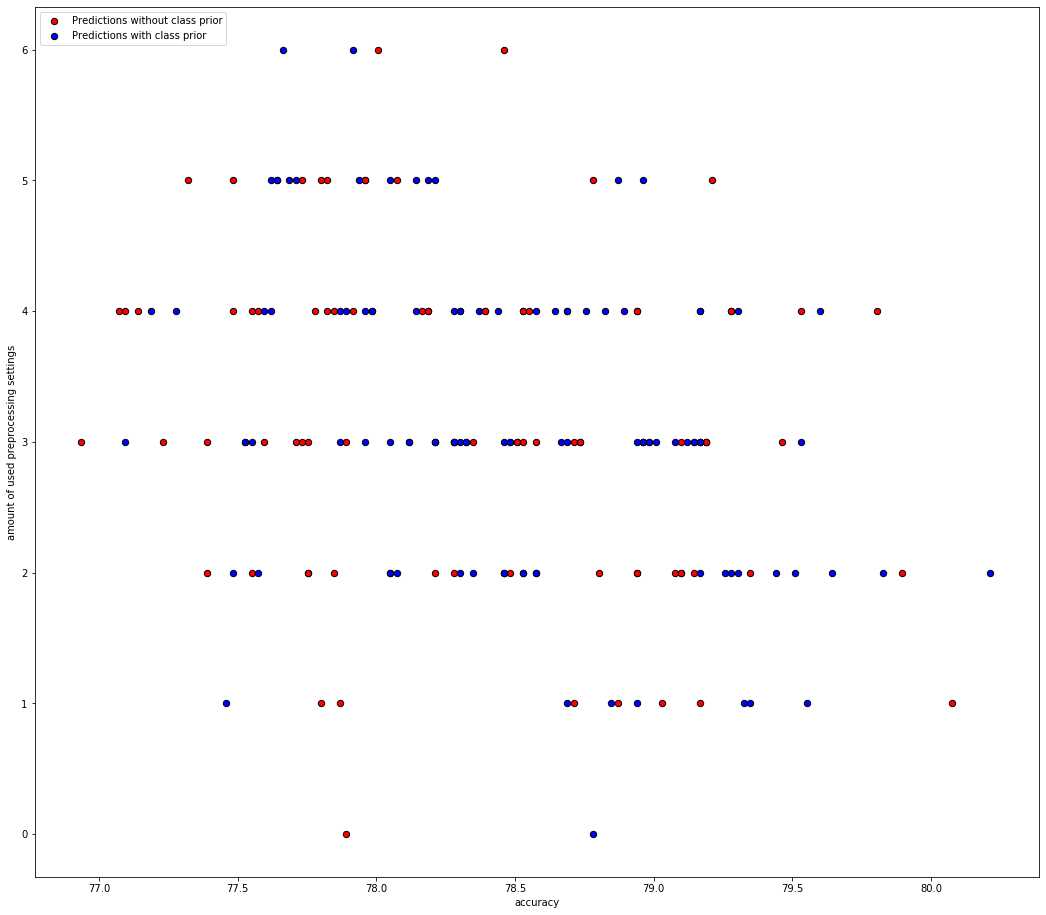

In [19]:
plotErrorRates(testing_array)

In [20]:
def getBestErrors(top, errors_and_parameters):
    errors = errors_and_parameters[0]
    
    indices_without_cp = np.argsort([i[0] for i in errors])[:top]
    indices_with_cp = np.argsort([i[1] for i in errors])[:top]
    
    errors_without_cp = list(np.array([i[0] for i in errors])[indices_without_cp])
    errors_with_cp = list(np.array([i[1] for i in errors])[indices_with_cp])
    
    parameters = errors_and_parameters[1]
    
    best_errors = [100 for i in range(top)]
    best_parameters = [[0,0,0,0,0,0,0] for i in range(top)]
    best_with_cp = [False for i in range(top)]
    
    two_tops = np.sort(errors_without_cp + errors_with_cp)

    result = []
    
    without_cp_counter = 0
    with_cp_counter = 0
    
    for i in range(top):
        actual_error = two_tops[i]
        actual_result = [actual_error]
        if(actual_error in errors_without_cp):
            actual_result.append(False)
            actual_result.append(parameters[indices_without_cp[without_cp_counter]])
            without_cp_counter += 1
        else:
            actual_result.append(True)
            actual_result.append(parameters[indices_with_cp[with_cp_counter]])
            with_cp_counter += 1
        
        result.append(actual_result)
    
    return result
                

In [21]:
best_errors_array = getBestErrors(20, testing_array)

In [22]:
def generateInfoAboutBestClassifiers(best_classifiers):
    preprocessings = ['emoji', 'punctuation', 'links', 'stopwords', 'negations', 'porter', 'lancaster']
            
    df = pd.DataFrame()
    df['accuracy'] = ''
    df['class_prior'] = ''
    df['used_preprocessing'] = ''
    
    for i in range(len(best_errors_array)):
        actual_row = []
        actual_row.append(100 - best_classifiers[i][0])
        actual_row.append(best_classifiers[i][1])
        
        actual_preprocessing_indices = best_classifiers[i][2]
        
        actual_preprocessing = ''

        for j in range(len(actual_preprocessing_indices)):
            if(actual_preprocessing_indices[j]): actual_preprocessing += preprocessings[j] + ', '

        actual_preprocessing = actual_preprocessing[:-2]
        actual_row.append(actual_preprocessing)
        
        df.loc[i] = actual_row
    
    return df

In [23]:
generateInfoAboutBestClassifiers(best_errors_array)

,accuracy,class_prior,used_preprocessing
0,80.214026,True,"emoji, links"
1,80.077413,False,punctuation
2,79.895264,False,"punctuation, porter"
3,79.826958,True,"punctuation, porter"
4,79.804189,False,"emoji, punctuation, links, lancaster"
5,79.644809,True,"emoji, punctuation"
6,79.599271,True,"emoji, punctuation, negations, lancaster"
7,79.553734,True,negations
8,79.530965,False,"punctuation, links, negations, porter"
9,79.530965,False,"emoji, punctuation, negations"


In [24]:
def checkNBClassificationsWithNgram(data, how_many_loops, cp_use, ngram):
    best_error_rate = 100
    
    size = 0.3
    for i in range(2 * how_many_loops):
        X_train, X_test, y_train, y_test = train_test_split(data['text'], data['airline_sentiment'], test_size = size)

        count_words = CountVectorizer(ngram_range=(1, ngram))
        train_words = count_words.fit_transform(X_train)
        train_targets = y_train

        if(cp_use):
            cp = generateClassPrior(train_targets)
            clf = MultinomialNB(alpha = 0.2, class_prior = cp)
        else:               
            clf = MultinomialNB(alpha = 0.2)

        clf.fit(train_words, train_targets)

        test_words = count_words.transform(X_test)

        predicts = clf.predict(test_words)

        error_rate = (sum(predicts != y_test) / len(y_test)) * 100

        if(error_rate < best_error_rate):
            best_error_rate = error_rate
    
    return best_error_rate

In [25]:
def testN_gramOnBestClassifier(data, best_classifiers):
    max_ngram = 6
    
    best_classifier_parameters = best_classifiers[0][2]
    class_prior = best_classifiers[0][1]
    preprocessed_data = preprocessing(data, best_classifier_parameters)
    
    ngram_errors = [0 for i in range(max_ngram - 2)]
    
    for i in range(2, max_ngram, 1):
        ngram_errors[i - 2] = checkNBClassificationsWithNgram(preprocessed_data, 5, class_prior, i)
    
    ngram_errors.insert(0, best_classifiers[0][0])
    
    return ngram_errors
    
        

In [26]:
ngram_errors = testN_gramOnBestClassifier(data, best_errors_array)

In [27]:
def plotNgramErrors(errors):
    ngram_parametrs = [i + 1 for i in range(len(errors))]
    
    errors = changeErrorRatesToAccuracy(errors.copy())
    
    figure(figsize = (9, 8))
    plt.scatter(errors, ngram_parametrs, c='red',cmap='spring', edgecolors='k', s=40)
    plt.xlabel('accuracy')
    plt.ylabel('ngram parameter')

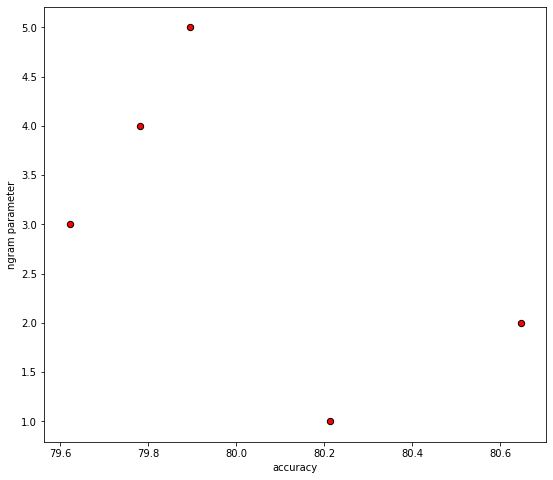

In [28]:
plotNgramErrors(ngram_errors)

In [29]:
def copyData(X_traing, y_train):
    count_targets = Counter(y_train)
                
    negatives = count_targets['negative']
    neutrals = count_targets['neutral']
    positives = count_targets['positive']
    
    actual_negative = 0
    actual_neutral = 0
    actual_positive = 0
    
    while(negatives != neutrals or neutrals != positives or positives != negatives):
    
        for elem in(y_train.index):
            if(str(type(y_train[elem])) == '''<class 'pandas.core.series.Series'>'''): continue
            
            if(negatives < neutrals and y_train[elem] == 'negative'):

                X_traing = X_traing.append(pd.Series(X_traing[elem]))
                y_train = y_train.append(pd.Series(y_train[elem]))

                negatives += 1

            if(neutrals < positives and y_train[elem] == 'neutral'):

                X_traing = X_traing.append(pd.Series(X_traing[elem]))
                y_train = y_train.append(pd.Series(y_train[elem]))

                neutrals += 1

            if(positives < negatives and y_train[elem] == 'positive'):

                X_traing = X_traing.append(pd.Series(X_traing[elem]))
                y_train = y_train.append(pd.Series(y_train[elem]))

                positives += 1
    
    return [X_traing, y_train]

In [30]:
def checkNBClassificationsWithDuplicatingData(data, how_many_loops):
    best_error_rate = 100
    
    size = 0.3
    for i in range(2 * how_many_loops):
        X_train, X_test, y_train, y_test = train_test_split(data['text'], data['airline_sentiment'], test_size = size)

        X_train, y_train = copyData(X_train, y_train)
        
        count_words = CountVectorizer()
        train_words = count_words.fit_transform(X_train)
        train_targets = y_train
              
        clf = MultinomialNB(alpha = 0.2)

        clf.fit(train_words, train_targets)

        test_words = count_words.transform(X_test)

        predicts = clf.predict(test_words)

        error_rate = (sum(predicts != y_test) / len(y_test)) * 100

        if(error_rate < best_error_rate):
            best_error_rate = error_rate
    
    return best_error_rate

In [31]:
def testDuplicatingDataOnBestClassifier(data, best_classifiers):
    best_cp_parameters = 0
    best_without_cp_parameters = 0
    
    duplicating_data_errors = [0 for i in range(4)]
    
    for classifier in(best_classifiers):
        if(best_cp_parameters != 0 and best_without_cp_parameters != 0): break
            
        if(classifier[1] and best_cp_parameters == 0):
            best_cp_parameters = classifier[2]
            duplicating_data_errors[0] = classifier[0]
            
        if(not(classifier[1]) and best_without_cp_parameters == 0):
            best_without_cp_parameters = classifier[2]
            duplicating_data_errors[1] = classifier[0]
    
    preprocessed_cp_data = preprocessing(data, best_cp_parameters)
    preprocessed_witohut_cp_data = preprocessing(data, best_without_cp_parameters)  
    
    duplicating_data_errors[2] = checkNBClassificationsWithDuplicatingData(preprocessed_cp_data, 5)
    duplicating_data_errors[3] = checkNBClassificationsWithDuplicatingData(preprocessed_witohut_cp_data, 5)
    
    return duplicating_data_errors

In [32]:
duplicating_data_errors = testDuplicatingDataOnBestClassifier(data, best_errors_array)

In [39]:
def plotCopyErrors(errors):
    
    plt.figure()
    figure(figsize = (18, 8))
    plt.hlines(1, 100 - max(errors) - 0.5, 100 - min(errors) + 0.5)
    plt.eventplot([100 - errors[0]], orientation='horizontal', colors='b', linestyles='solid', linelengths=0.5, label='standard classifier with class prior')
    plt.eventplot([100 - errors[1]], orientation='horizontal', colors='b', linestyles='dashed', linelengths=0.5, label='standard classifier without class prior')
    plt.eventplot([100 - errors[2]], orientation='horizontal', colors='r', linestyles='solid', linelengths=0.5, label='classifier with class prior and with data duplication')
    plt.eventplot([100 - errors[3]], orientation='horizontal', colors='r', linestyles='dashed', linelengths=0.5, label='classifier without class prior and with data duplication')
    
    plt.legend(loc="upper left")
    
    plt.xlabel('accuracy')
    plt.yticks([])
    
    plt.show()

<Figure size 432x288 with 0 Axes>

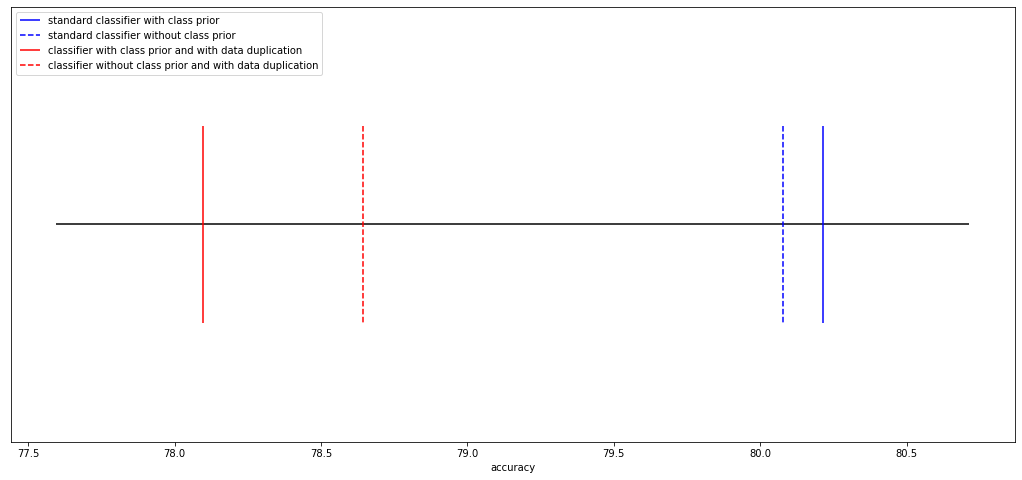

In [40]:
plotCopyErrors(duplicating_data_errors)

## Kaggle Competition bug analysis

In [2]:
kaggle_data = pd.read_csv('kaggle.csv')
kaggle_data = kaggle_data.drop(["handle", 'Unnamed: 0'], axis=1)

In [3]:
def cutNormalWords(data):
    data['text'] = data.text.str.split()
    data['text'] = data['text'].apply(lambda x: [word for word in x if word[0] == '@' or word[0] == '#'])
    data['text'] = data['text'].apply(lambda x: [word[1:] for word in x])
    data['text'] = data.text.str.join(' ')
    
    data = data[data.text != '']
    
    return data

In [4]:
kaggle_data = cutNormalWords(kaggle_data)

In [5]:
def createSpecialWordsDataframe(data):
    data['text'] = data.text.str.split()
    
    result = pd.DataFrame()
    result['word'] = ''
    
    result['biz&tech'] = ''
    result['politician'] = ''
    result['celebrity'] = ''
    result['internetplatform'] = ''
    
    actual_new_row = 0
    i = 0
    
    while(i < len(data)):
            
        try: data.loc[i]['text']
        except: 
            i += 1
            continue
            
        for word in(data.loc[i]['text']):
        
            target = data.loc[i]['target']
            
            try:
                index = result.index[result['word'] == word].tolist()[0]
                result.loc[index][target] += 1
                
            except:
                result.loc[actual_new_row] = [word, 0, 0, 0, 0]
                result.loc[actual_new_row][target] += 1
                actual_new_row += 1
        i += 1
    
    return result

In [6]:
words_dataframe = createSpecialWordsDataframe(kaggle_data.copy())

In [7]:
def printTargetSums(data):
    print('biz&tech: ' , data['biz&tech'].sum())
    print('politician: ' , data['politician'].sum())
    print('celebrity: ' , data['celebrity'].sum())
    print('internetplatform: ' , data['internetplatform'].sum())

In [8]:
printTargetSums(words_dataframe)

biz&tech:  1840
politician:  4960
celebrity:  8361
internetplatform:  2684


In [9]:
def printTargetsMax(insert_data, which_max):
    data = insert_data.copy()
    
    for i in range(which_max - 1):
        biz_index = data.index[data['biz&tech'] == data['biz&tech'].max()].tolist()[0]
        data = data.drop(index = biz_index)

        politician_index = data.index[data['politician'] == data['politician'].max()].tolist()[0]
        data = data.drop(index = politician_index)
        
        celebrity_index = data.index[data['celebrity'] == data['celebrity'].max()].tolist()[0]
        data = data.drop(index = celebrity_index)
        
        internetplatform_index = data.index[data['internetplatform'] == data['internetplatform'].max()].tolist()[0]
        data = data.drop(index = internetplatform_index)
        
        
    biz_index = data.index[data['biz&tech'] == data['biz&tech'].max()].tolist()[0]
    politician_index = data.index[data['politician'] == data['politician'].max()].tolist()[0]
    celebrity_index = data.index[data['celebrity'] == data['celebrity'].max()].tolist()[0]
    internetplatform_index = data.index[data['internetplatform'] == data['internetplatform'].max()].tolist()[0]
    
    print(data.loc[biz_index])
    print()
    print(data.loc[politician_index])
    print()
    print(data.loc[celebrity_index])
    print()
    print(data.loc[internetplatform_index])

In [18]:
printTargetsMax(words_dataframe, 2)

word                kaggle's
biz&tech                  47
politician                 0
celebrity                  0
internetplatform           0
Name: 11, dtype: object

word                realDonaldTrump
biz&tech                          2
politician                      292
celebrity                         1
internetplatform                  6
Name: 254, dtype: object

word                Skrillex
biz&tech                   0
politician                 0
celebrity                 69
internetplatform           0
Name: 3076, dtype: object

word                TNF
biz&tech              0
politician            0
celebrity             0
internetplatform     66
Name: 6190, dtype: object
